# This notebook contains:
* Function to get filepaths for temperature and specific humidity at different pressure levels
* Function to combine temp/humidity into one dataset across the vertical profile
* Function to calculate equivalent potential temperature (theta-e) from temp/specific humidity
* Function to calculate mean hourly theta-e for different wind regimes and plot
* Function to calculate overall mean vertical profiles of theta-e and plot

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
from numpy import s_
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from collections import defaultdict
import metpy
import metpy.calc as mpcalc
from metpy.units import units
from scipy.interpolate import griddata
from datetime import datetime
import pandas as pd
import dask

# Calculating temp and spc humidity for each pressure level

In [2]:
# create file lists to open using dask
def file_paths(variable):
    list = ["202201-202201","202202-202202","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
           "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
           "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
           "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
           "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
           "201203-201203","201204-201204"]
    list.sort()
    file_paths = []
    for i in list:
        fp = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/"+variable+"/v20231001/"
        all_files = [fp+variable+"_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_"+i+".nc"]
        file_paths.extend(all_files)
    file_paths.sort()
    return file_paths  
# ta1000 = file_paths("ta1000") 
ta950 = file_paths("ta950") 
ta925 = file_paths("ta925") 
ta850 = file_paths("ta850") 
ta700 = file_paths("ta700") 
ta600 = file_paths("ta600") 
ta500 = file_paths("ta500") 
ta400 = file_paths("ta400")
ta300 = file_paths("ta300") 
ta200 = file_paths("ta200")
# hus1000 = file_paths("hus1000") 
hus950 = file_paths("hus950") 
hus925 = file_paths("hus925") 
hus850 = file_paths("hus850") 
hus700 = file_paths("hus700") 
hus600 = file_paths("hus600") 
hus500 = file_paths("hus500") 
hus400 = file_paths("hus400")
hus300 = file_paths("hus300") 
hus200 = file_paths("hus200")

In [3]:
%%time
def open_and_combine(filepaths,variable_in_fp):
    list = filepaths
    datasets_towns=[]
    datasets_cairns=[]
    datasets_willis=[]
    for fp in list:
        with xr.open_mfdataset(fp, engine="h5netcdf", chunks="auto") as ds:
            towns = ds.sel(lat=-19.4198,lon=146.5509,method="nearest").drop_vars('pressure')
            cairns = ds.sel(lat=-16.817,lon=145.683,method="nearest").drop_vars('pressure')
            willis = ds.sel(lat=-16.2874,lon=149.9646,method="nearest").drop_vars('pressure')

            # in filepath string variable name is listed- extract to select
            towns = towns[fp[0][124:variable_in_fp]] 
            cairns = cairns[fp[0][124:variable_in_fp]]
            willis = willis[fp[0][124:variable_in_fp]]
            
            datasets_towns.append(towns)
            datasets_cairns.append(cairns)
            datasets_willis.append(willis)
            ds.close()
    # combine result for each pressure level into one array
    combine_towns = xr.combine_by_coords(datasets_towns)
    combine_cairns = xr.combine_by_coords(datasets_cairns)
    combine_willis = xr.combine_by_coords(datasets_willis)
    return combine_towns,combine_cairns,combine_willis

ta_towns,ta_cairns,ta_willis=open_and_combine([ta950,ta925,ta850,ta700,ta600,ta500,ta400,ta300,ta200],129)
spc_towns,spc_cairns,spc_willis=open_and_combine([hus950,hus925,hus850,hus700,hus600,hus500,hus400,hus300,hus200],130)

0.3.0
CPU times: user 57.6 s, sys: 21.2 s, total: 1min 18s
Wall time: 3min 31s


# Calculating eqpt 

In [4]:
from metpy.constants import Rd, g
from metpy.xarray import preprocess_and_wrap

def eqpt_approx(p, t, q):
    """
    Computes equivalent potential temperature in [K] from pressure,
    temperature and specific humidity.

    Arguments:
    p -- pressure in [Pa]
    t -- temperature in [K]
    q -- specific humidity in [kg/kg]

    p, t and q can be scalars or np arrays.

    Returns: equivalent potential temperature in [K].
    """
    return mpcalc.equivalent_potential_temperature(
        units.Pa * p, units.K * t,
        mpcalc.dewpoint_from_specific_humidity(units.Pa * p, units.K * t, q)).to("K").m

In [5]:
# open barra 850hPa wind files to create composites
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

In [6]:
# Define a delayed function for the calculation of mean per hour (diurnal analysis)
def calculate_mean(hour, wind_dir, ds):
    wind_times_hour = wind_dir.groupby(wind_dir.time.dt.hour == hour)
    wind_result = wind_times_hour[1].time.values
    ds_regime = ds.sel(time=wind_result)
    mean_values_lazy = da.delayed(ds_regime.drop_vars(["lon", "lat"]).mean(dim='time'))
    return mean_values_lazy

In [7]:
%%time
import dask as da
def mean_results_hourly(barra_ds,deg1,deg2,barra_variable_fp,ne=None,all_winds=None):
    winds = barra_ds.wind_dir.compute()
    if ne==True:
        winds_dir = winds[(winds>=deg1)&(winds<=deg2)]
    else:
        winds_dir = winds[(winds>deg1)&(winds<=deg2)]
    if all_winds==True:
        winds_dir = winds
    else:
        pass
    mean_values = []
    # use defined function to calc mean
    for hour in np.arange(0, 24, 1):
        mean_values.append(calculate_mean(hour, winds_dir, barra_variable_fp)) 
    return da.compute(mean_values, scheduler='processes')[0]

CPU times: user 7 µs, sys: 7 µs, total: 14 µs
Wall time: 23.4 µs


In [8]:
 # extract values into an array
def extract_values(mean_result):
    values_UTC = []
    for hour in np.arange(0,24,1):
        mean_values_array = mean_result[hour]
        var_names = list(mean_values_array.data_vars.keys())
        result = [mean_values_array[var].values for var in reversed(var_names)]
        values_UTC.append(result)
    return values_UTC

In [9]:
%%time
# run functions to get UTC (24,9) shaped arrays of mean variable values for each pressure level each hour
ta_newinds_UTC = mean_results_hourly(barra_towns,0,90,ta_towns,ne=True,all_winds=False)
ta_ne_UTC = extract_values(ta_newinds_UTC)
ta_nwwinds_UTC = mean_results_hourly(barra_towns,270,360,ta_towns,ne=False,all_winds=False)
ta_nw_UTC = extract_values(ta_nwwinds_UTC)
ta_sewinds_UTC = mean_results_hourly(barra_towns,90,180,ta_towns,ne=False,all_winds=False)
ta_se_UTC = extract_values(ta_sewinds_UTC)
ta_swwinds_UTC = mean_results_hourly(barra_towns,180,270,ta_towns,ne=False,all_winds=False)
ta_sw_UTC = extract_values(ta_swwinds_UTC)
ta_winds_UTC = mean_results_hourly(barra_towns,270,360,ta_towns,ne=False,all_winds=True)
ta_UTC = extract_values(ta_winds_UTC)

CPU times: user 3min 53s, sys: 17.5 s, total: 4min 10s
Wall time: 20min 36s


In [10]:
%%time
# same as above but for specific humidity
spc_newinds_UTC = mean_results_hourly(barra_towns,0,90,spc_towns,ne=True,all_winds=False)
spc_ne_UTC = extract_values(spc_newinds_UTC)
spc_sewinds_UTC = mean_results_hourly(barra_towns,90,180,spc_towns,ne=False,all_winds=False)
spc_se_UTC = extract_values(spc_sewinds_UTC)
spc_swwinds_UTC = mean_results_hourly(barra_towns,180,270,spc_towns,ne=False,all_winds=False)
spc_sw_UTC = extract_values(spc_swwinds_UTC)
spc_nwwinds_UTC = mean_results_hourly(barra_towns,270,360,spc_towns,ne=False,all_winds=False)
spc_nw_UTC = extract_values(spc_nwwinds_UTC)
spc_winds_UTC = mean_results_hourly(barra_towns,270,360,spc_towns,ne=False,all_winds=True)
spc_UTC = extract_values(spc_winds_UTC)

CPU times: user 4min 4s, sys: 18.2 s, total: 4min 22s
Wall time: 21min 2s


In [11]:
# convert to eqpt
pressure = np.array([95000,92500,85000,70000,60000,50000,40000,30000,20000])
eqpt_NE = []
eqpt_SE = []
eqpt_SW = []
eqpt_NW = []
eqpt = []
for hour in np.arange(0,24,1):
    eqpt.append(eqpt_approx(pressure, np.array(ta_UTC[hour]), np.array(spc_UTC[hour])))
    eqpt_NE.append(eqpt_approx(pressure, np.array(ta_ne_UTC[hour]), np.array(spc_ne_UTC[hour])))
    eqpt_SE.append(eqpt_approx(pressure, np.array(ta_se_UTC[hour]), np.array(spc_se_UTC[hour])))
    eqpt_SW.append(eqpt_approx(pressure, np.array(ta_sw_UTC[hour]), np.array(spc_sw_UTC[hour])))
    eqpt_NW.append(eqpt_approx(pressure, np.array(ta_nw_UTC[hour]), np.array(spc_nw_UTC[hour])))

In [12]:
eqpt_roll = np.roll(eqpt,shift=10,axis=0)
eqpt_NE_roll = np.roll(eqpt_NE,shift=10,axis=0)
eqpt_SE_roll = np.roll(eqpt_SE,shift=10,axis=0)
eqpt_SW_roll = np.roll(eqpt_SW,shift=10,axis=0)
eqpt_NW_roll = np.roll(eqpt_NW,shift=10,axis=0)

# Load saved array from above calculations

In [3]:
# save eqpt results as numpy array dataset
# np.save('/home/563/ac9768/barra-2/eqpt_NW_towns.npy', eqpt_NW_roll)
eqpt = np.load('/home/563/ac9768/barra-2/eqpt/eqpt_cairns.npy')
eqpt_NE = np.load('/home/563/ac9768/barra-2/eqpt/eqpt_NE_cairns.npy')
eqpt_SE = np.load('/home/563/ac9768/barra-2/eqpt/eqpt_SE_cairns.npy')
eqpt_SW = np.load('/home/563/ac9768/barra-2/eqpt/eqpt_SW_cairns.npy')
eqpt_NW = np.load('/home/563/ac9768/barra-2/eqpt/eqpt_NW_cairns.npy')

Text(0.5, 0, 'Hour (AEST)')

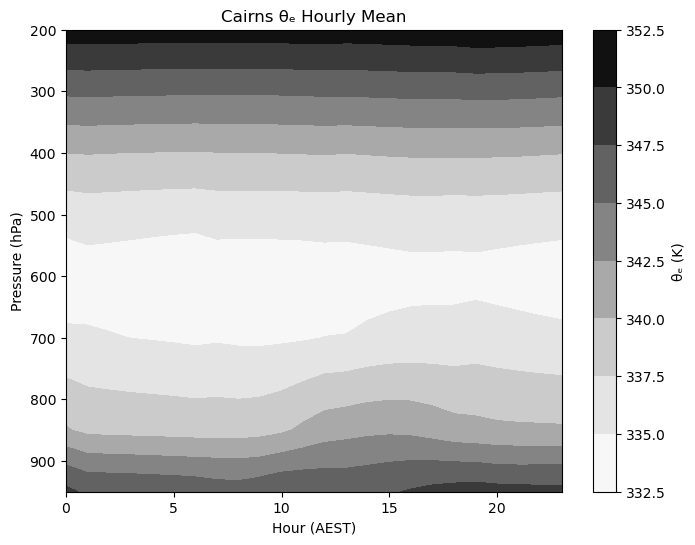

In [4]:
fig,ax = plt.subplots(1,1, figsize=[8,6])
pressure = np.array([95000,92500,85000,70000,60000,50000,40000,30000,20000])
ax.invert_yaxis()
eqptT = eqpt.T
clim=ax.contourf(np.arange(0,24,1),pressure,eqptT,cmap="Greys")
plt.colorbar(clim,label='θ\u2091 (K)',ax=ax)
plt.title('Cairns θ\u2091 Hourly Mean')
yticklabels = ["200","300","400","500","600","700","800","900"]
ax.set_yticks(np.arange(20000,100000,10000),yticklabels)
ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel('Hour (AEST)')

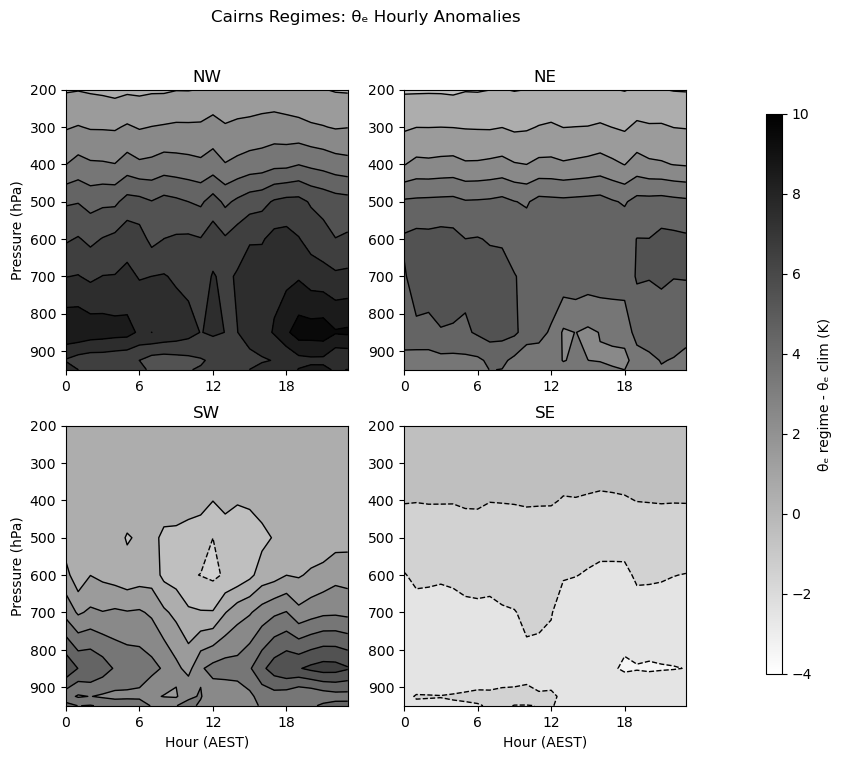

In [19]:
def plot_eqpt(site,eqpt,eqpt_NE,eqpt_SE,eqpt_SW,eqpt_NW,single_plot=None):
    yticklabels = ["200","300","400","500","600","700","800","900"]
    if single_plot==True:
        fig,ax = plt.subplots(1,1, figsize=[8,8])
        ax.invert_yaxis()
        for i in np.arange(0,23,1):
            ax.plot(eqpt[i],pressure,color="black",linestyle='--',linewidth=0.5)
            ax.plot(eqpt_NE[i],pressure,color="seagreen",linewidth=0.2)
            ax.plot(eqpt_NW[i],pressure,color="gold",linewidth=0.2)
            ax.plot(eqpt_SE[i],pressure,color="royalblue",linewidth=0.2)
            ax.plot(eqpt_SW[i],pressure,color="purple",linewidth=0.2)
        ax.plot(eqpt[23],pressure,label="Clim",color="black",linestyle='--',linewidth=0.5)
        ax.plot(eqpt_NE[23],pressure,label="NE",color="seagreen",linewidth=0.2)
        ax.plot(eqpt_SE[23],pressure,label="SE",color="royalblue",linewidth=0.2)
        ax.plot(eqpt_SW[23],pressure,label="SW",color="purple",linewidth=0.2)
        ax.plot(eqpt_NW[23],pressure,label="NW",color="gold",linewidth=0.2)
        plt.legend()
        ax.set_yticks(np.arange(20000,100000,10000),yticklabels)
        ax.set_ylabel("Pressure (hPa)")
        ax.set_xlabel("θ\u2091 (K)")
        ax.grid()
        ax.set_xlim(331,357.5)
    else:
        fig,ax = plt.subplots(2,2, figsize=[8,8])
        ax[0,0].invert_yaxis()
        ax[0,1].invert_yaxis()
        ax[1,0].invert_yaxis()
        ax[1,1].invert_yaxis()
        # plot regimes as mean values or difference from mean climatological conditions
        levels = np.arange(-4,11,1) #np.arange(330,358,3)
        eqpt_NET = eqpt_NE.T
        ne=ax[0,1].contourf(np.arange(0,24,1),pressure,eqpt_NET-eqptT,levels=levels,cmap="binary")
        ax[0,1].contour(np.arange(0,24,1),pressure,eqpt_NET-eqptT,levels=levels,colors="black",linewidths=1)
        # plt.colorbar(ne,label='θ\u2091 (K)',ax=ax[0,1])
        eqpt_SET = eqpt_SE.T
        se=ax[1,1].contourf(np.arange(0,24,1),pressure,eqpt_SET-eqptT,levels=levels,cmap="binary")
        ax[1,1].contour(np.arange(0,24,1),pressure,eqpt_SET-eqptT,levels=levels,colors="black",linewidths=1)
        # plt.colorbar(se,label='θ\u2091 (K)',ax=ax[1,1])
        eqpt_SWT = eqpt_SW.T
        sw=ax[1,0].contourf(np.arange(0,24,1),pressure,eqpt_SWT-eqptT,levels=levels,cmap="binary")
        ax[1,0].contour(np.arange(0,24,1),pressure,eqpt_SWT-eqptT,levels=levels,colors="black",linewidths=1)
        # plt.colorbar(sw,ax=ax[1,0])
        eqpt_NWT = eqpt_NW.T
        nw=ax[0,0].contourf(np.arange(0,24,1),pressure,eqpt_NWT-eqptT,levels=levels,cmap="binary")
        ax[0,0].contour(np.arange(0,24,1),pressure,eqpt_NWT-eqptT,levels=levels,colors="black",linewidths=1)
        # plt.colorbar(nw,ax=ax[0,0])
        cax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        # # Create a colorbar using the ScalarMappable from one of the subplots
        sm = plt.cm.ScalarMappable(cmap="binary")
        sm.set_array(levels)  # You need to set an array for the ScalarMappable
        cbar = plt.colorbar(sm,label='θ\u2091 regime - θ\u2091 clim (K)', cax=cax)
        ax[0,0].set_yticks(np.arange(20000,100000,10000),yticklabels)
        ax[0,1].set_yticks(np.arange(20000,100000,10000),yticklabels)
        ax[1,1].set_yticks(np.arange(20000,100000,10000),yticklabels)
        ax[1,0].set_yticks(np.arange(20000,100000,10000),yticklabels)
        
        ax[0,0].set_xticks(np.arange(0,24,6))
        ax[0,1].set_xticks(np.arange(0,24,6),)
        ax[1,1].set_xticks(np.arange(0,24,6),)
        ax[1,0].set_xticks(np.arange(0,24,6),)
        ax[0,0].set_title('NW')
        ax[0,1].set_title('NE')
        ax[1,1].set_title('SE')
        ax[1,0].set_title('SW')
        ax[0,0].set_ylabel("Pressure (hPa)")
        ax[1,0].set_ylabel("Pressure (hPa)")
        ax[1,0].set_xlabel("Hour (AEST)")
        ax[1,1].set_xlabel("Hour (AEST)")
    plt.suptitle(site+' Regimes: θ\u2091 Hourly Anomalies')
    return plt.show


plot_eqpt("Cairns",eqpt,eqpt_NE,eqpt_SE,eqpt_SW,eqpt_NW,single_plot=False);

In [53]:
# define a function for lazily computing the mean across time for all variables
# to look at diurnal variability swap out wind regime for hour of day time steps (for each site) 
def compute_mean(ds,barra_site,deg1,deg2,regime=None,hours=None):
    if regime==True:
        winds = barra_site.wind_dir.compute()
        winds_dir = winds[(winds>deg1)&(winds<=deg2)]
        wind_times = winds_dir.time.values
        ds_regime = ds.sel(time=wind_times)
        mean_values_lazy = dask.delayed(ds_regime.drop_vars(["lon","lat"]).mean(dim='time'))
        mean_values = mean_values_lazy.compute(scheduler='processes')
    else:
        # Lazily compute the mean across the time dimension for all variables
        mean_values_lazy = dask.delayed(ds.drop_vars(["lon","lat"]).mean(dim='time'))
        # Compute mean values in parallel using Dask
        mean_values = mean_values_lazy.compute(scheduler='processes')
    list(mean_values.data_vars)
    return np.array([mean_values[var].values for var in reversed(var_names)]) # returns a np.array of mean values ordered: (900hPa,...,200hPa)

In [54]:
%%time
willis_ta_mean = compute_mean(ta_willis,barra_willis,270,360,regime=True,hours=False)
# willis_hus_mean = compute_mean(spc_willis,barra_willis,0,90,regime=True,hours=True)


CPU times: user 1.66 s, sys: 127 ms, total: 1.79 s
Wall time: 1min 44s


In [8]:
# arrays to calculate equivalent potential temperature
# averaged across all time periods, temp in K  
ta_profile_towns = np.array([296.23297,294.61948,290.93314,282.41202,275.9882,268.56326,257.9812,243.1838,221.66934])
ta_profile_cairns = np.array([296.311,294.71893,291.2063,282.83255,276.27072,269.05423,258.6164,243.76297,221.66801])
ta_profile_willis = np.array([295.98383,294.41638,291.12567,283.21655,276.5851,269.18927,258.6918,243.84871,221.67357]) 
# averaged across all time periods, specific humidity in kg/kg  
hus_profile_towns = np.array([0.01469911,0.01402218,0.01112136,0.00607313,0.00347916,0.00186964,0.00092744,0.00034398,5.183086e-05])
hus_profile_cairns = np.array([0.0155223,0.01482653,0.01154828,0.00694888,0.00424852,0.00227154,0.00108122,0.00039738,6.334724e-05])
hus_profile_willis = np.array([0.01620773,0.0152664,0.01145537,0.00653486,0.00403325,0.00224895,0.00108828,0.00039595,6.673288e-05])

# NE regime
ne_ta_profile_towns = np.array([296.1,294.4,291.2,282.8,275.7,268.7,258.4,243.6,221.6])
ne_hus_profile_towns = np.array([0.01617,0.01559,0.01236,0.007638,0.005184,0.003055,0.001449,0.0005091,6.882e-05])
ne_ta_profile_cairns = np.array([296.1,294.7,291.3,283.1,275.9,269.0,258.8,244.0,221.6])
ne_hus_profile_cairns = np.array([0.01676,0.01599,0.01294,0.008457,0.005969,0.003563,0.001615,0.00056,8.176e-05])
ne_ta_profile_willis = np.array([296.3,294.9,291.5,283.2,276.1,268.9,258.6,243.8,221.5])
ne_hus_profile_willis = np.array([0.01688,0.01577,0.01246,0.007746,0.005343,0.003175,0.001466,0.0005119,7.852e-05])

# SE
se_ta_profile_towns = np.array([295.7,294.1,290.3,282.2,276.1,268.4,257.7,242.9,221.6])
se_hus_profile_towns = np.array([0.01405,0.01344,0.01058,0.005235,0.002703,0.00139,0.0007308,0.0002803,4.458e-05])
se_ta_profile_cairns = np.array([295.7,294.0,290.6,282.7,276.3,269.0,258.4,243.5,221.5])
se_hus_profile_cairns = np.array([0.01505,0.01445,0.0109,0.006278,0.003633,0.001851,0.0008952,0.0003386,5.649e-05])
se_ta_profile_willis = np.array([295.6,293.8,290.6,283.1,276.7,269.1,258.5,243.6,221.5])
se_hus_profile_willis = np.array([0.01554,0.01484,0.01088,0.005775,0.003255,0.001654,0.0008115,0.0003146,5.772e-05])

# SW
sw_ta_profile_towns = np.array([299.6,298.4,293.9,282.8,276.2,269.1,258.9,244.1,222.5])
sw_hus_profile_towns = np.array([0.01461,0.01338,0.01112,0.00724,0.004033,0.001945,0.000908,0.000347,5.493e-05])
sw_ta_profile_cairns = np.array([299.0,297.7,293.6,282.9,276.3,269.4,259.1,244.2,222.2])
sw_hus_profile_cairns = np.array([0.01557,0.01458,0.01208,0.007556,0.004362,0.002148,0.001061,0.0003874,6.172e-05])
sw_ta_profile_willis = np.array([296.8,295.4,292.2,283.3,276.7,269.6,259.2,244.4,222.2])
sw_hus_profile_willis = np.array([0.0169,0.01545,0.01109,0.006343,0.003955,0.002267,0.001133,0.0003903,6.647e-05])

# NW
nw_ta_profile_towns = np.array([297.5,296.1,292.8,283.0,275.7,268.9,258.6,243.8,222.0])
nw_hus_profile_towns = np.array([0.01697,0.01595,0.01289,0.008334,0.00544,0.003008,0.001343,0.0004794,6.946e-05])
nw_ta_profile_cairns = np.array([297.8,296.4,292.6,283.5,276.4,269.5,259.4,244.7,222.3])
nw_hus_profile_cairns = np.array([0.0172,0.01629,0.0137,0.008998,0.006226,0.003719,0.001729,0.0006152,9.015e-05])
nw_ta_profile_willis = np.array([296.9,295.7,292.3,283.7,276.5,269.5,259.4,244.7,222.3])
nw_hus_profile_willis = np.array([0.01772,0.01633,0.01298,0.008429,0.005764,0.003619,0.001772,0.0006062,9.13e-05])

# pressure in Pa
pressure = np.array([95000,92500,85000,70000,60000,50000,40000,30000,20000])

In [9]:
# climatological means for each site
towns_eqpt = eqpt_approx(pressure, ta_profile_towns, hus_profile_towns)
cairns_eqpt = eqpt_approx(pressure, ta_profile_cairns, hus_profile_cairns)
willis_eqpt = eqpt_approx(pressure, ta_profile_willis, hus_profile_willis)
# towns regimes
ne_towns_eqpt = eqpt_approx(pressure, ne_ta_profile_towns, ne_hus_profile_towns)
se_towns_eqpt = eqpt_approx(pressure, se_ta_profile_towns, se_hus_profile_towns)
sw_towns_eqpt = eqpt_approx(pressure, sw_ta_profile_towns, sw_hus_profile_towns)
nw_towns_eqpt = eqpt_approx(pressure, nw_ta_profile_towns, nw_hus_profile_towns)
# cairns regimes
ne_cairns_eqpt = eqpt_approx(pressure, ne_ta_profile_cairns, ne_hus_profile_cairns)
se_cairns_eqpt = eqpt_approx(pressure, se_ta_profile_cairns, se_hus_profile_cairns)
sw_cairns_eqpt = eqpt_approx(pressure, sw_ta_profile_cairns, sw_hus_profile_cairns)
nw_cairns_eqpt = eqpt_approx(pressure, nw_ta_profile_cairns, nw_hus_profile_cairns)
# willis regimes
ne_willis_eqpt = eqpt_approx(pressure, ne_ta_profile_willis, ne_hus_profile_willis)
se_willis_eqpt = eqpt_approx(pressure, se_ta_profile_willis, se_hus_profile_willis)
sw_willis_eqpt = eqpt_approx(pressure, sw_ta_profile_willis, sw_hus_profile_willis)
nw_willis_eqpt = eqpt_approx(pressure, nw_ta_profile_willis, nw_hus_profile_willis)

Text(0.5, 0.98, 'Willis Island')

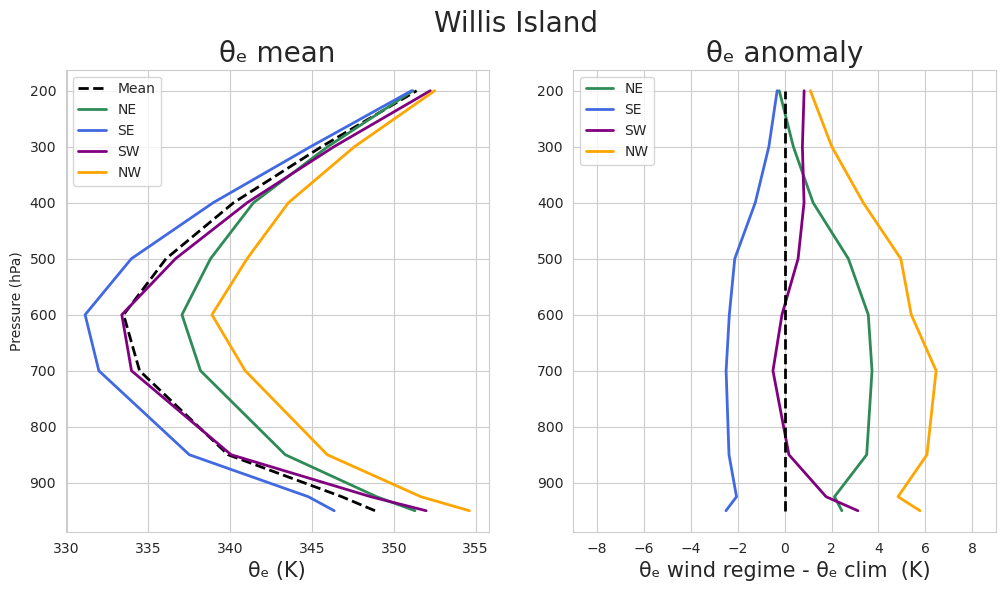

In [47]:
import seaborn as sns
sns.set_style("whitegrid")
fig,ax = plt.subplots(1,2, figsize=[12,6])
#plot mean
ax[0].plot(willis_eqpt,pressure,label="Mean",color="black",linestyle='--',linewidth=2)
ax[0].plot(ne_willis_eqpt,pressure,label="NE",color="seagreen",linewidth=2)
ax[0].plot(se_willis_eqpt,pressure,label="SE",color="royalblue",linewidth=2)
ax[0].plot(sw_willis_eqpt,pressure,label="SW",color="purple",linewidth=2)
ax[0].plot(nw_willis_eqpt,pressure,label="NW",color="orange",linewidth=2)
# plot anomalies
ax[1].plot(ne_willis_eqpt-willis_eqpt,pressure,label="NE",color="seagreen",linewidth=2)
ax[1].plot(se_willis_eqpt-willis_eqpt,pressure,label="SE",color="royalblue",linewidth=2)
ax[1].plot(sw_willis_eqpt-willis_eqpt,pressure,label="SW",color="purple",linewidth=2)
ax[1].plot(nw_willis_eqpt-willis_eqpt,pressure,label="NW",color="orange",linewidth=2)
# plot dashed line for climatological average
pressure = np.array([95000,92500,85000,70000,60000,50000,40000,30000,20000])
ax[1].plot([0]*(len(pressure)),pressure,color="black",linestyle="--",linewidth=2)
# other plot stuff
ax[0].legend()
ax[1].legend(loc="upper left")
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.xlim(-9,9)
yticklabels = ["200","300","400","500","600","700","800","900"]
ax[0].set_yticks(np.arange(20000,100000,10000),yticklabels)
ax[1].set_yticks(np.arange(20000,100000,10000),yticklabels)
ax[0].set_ylabel("Pressure (hPa)")
ax[0].set_xlabel("θ\u2091 (K)",fontsize=15)
ax[1].set_xlabel("θ\u2091 wind regime - θ\u2091 clim  (K)",fontsize=15)
ax[0].set_title("θ\u2091 mean",fontsize=20)
ax[1].set_title("θ\u2091 anomaly",fontsize=20)
fig.suptitle("Willis Island",fontsize=20)

# Open regridded himawari data

In [12]:
def him8_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith("_ch13BT_regridded_2kmres.nc"):  # Check for the ".nc" file extension
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/home/563/ac9768/"
files = him8_files(directory)

In [53]:
%%time
ds_him8 = xr.open_mfdataset(files,engine="h5netcdf",chunks="auto")

CPU times: user 179 ms, sys: 45.4 ms, total: 225 ms
Wall time: 474 ms


In [120]:
hours = ds_him8.ch13BT.sel(lat=-16.2874,method="nearest").groupby(ds_him8.time.dt.hour).mean()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
18
19
20
21
22
23


In [189]:
diurnal_bt_aest = np.roll(diurnal_bt,shift=10,axis=0) 
diurnal_bt_med_aest = np.roll(diurnal_bt_median,shift=10,axis=0) 
diurnal_temp_aest = np.roll(temp_surf,shift=10,axis=0) #
double_him_mean = np.concatenate([diurnal_bt_aest,diurnal_bt_aest])
double_him = np.concatenate([diurnal_bt_med_aest,diurnal_bt_med_aest])
double_barra_temp = np.concatenate([diurnal_temp_aest,diurnal_temp_aest]) 
double_barra = np.concatenate([eqpt_aest,eqpt_aest]) #eqpt_aest

In [192]:
np.shape(double_barra_temp)

(48, 452, 82)

TypeError: Input z must be 2D, not 3D

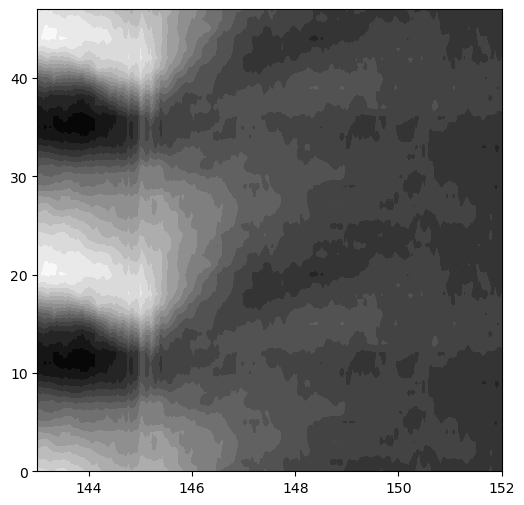

In [190]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
fig.patch.set_facecolor('white')
cf=ax.contourf(ds_him8.lon,np.arange(0,48,1),double_him_mean,levels=16,cmap='binary')
cf1=ax.contour(temp_850_concat.lon,np.arange(0,48,1),double_barra_temp,levels=np.arange(338,350,0.5),cmap='viridis') #np.arange(291,293.3,0.2)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
sm.set_array(np.arange(340,350.5,0.5))  # You need to set an array for the ScalarMappable        
cax = fig.add_axes([0.93, 0.105, 0.037, 0.775])  # [left, bottom, width, height]
cbar1 = plt.colorbar(sm,cax=cax,orientation='vertical')#,ticks=np.arange(320,330,1))
cbar1.set_label('Equivalent Potential Temperature at 850hPa (K)',rotation=270)
cbar = plt.colorbar(cf,pad=0.05)
cbar.set_label("Mean Brightness Temperature (K)",rotation=270)
cbar.ax.yaxis.set_label_coords(3.5, 0.5)
cbar1.ax.yaxis.set_label_coords(3, 0.5)
cbar.ax.tick_params(labelsize=8)
cbar1.ax.tick_params(labelsize=8)
ax.set_yticks(np.arange(0,48,6))
ax.set_ylabel('Hour (AEST)')
ax.set_xlabel('Longitude')
fig.suptitle('Willis Island Himawari-8 Hovmöller',fontsize=20);
# ax.set_title('Brightness temperature & 850hPa temperature contours',fontsize=8)